## Анализ отзывов

В рамках данного кейса предлагается с помощью ИИ и машинного обучения поизучать отзывы людей на железнодорожные вокзалы Москвы. В рамках кейса предоставляются отзывы пользователей с Яндекс-карт, но возможно дополнительно использовать доступные в Интернет данные. 

Что ожидается в качестве результата:
* Инфографика, наглядно демонстрирующая полученные командой результаты
* Доклад, представляющий эти результаты
* Код в Jupyter Notebook с анализом данных

В данном ноутбуке показывается, как получить доступ к датасету, и первые шаги по его обработке с помощью доступных открытых моделей с HuggingFace, и с помощью YandexGPT. Можно использовать данный ноутбук как оправную точку для выполнения задания, расширив его дополнительными идеями, например:
* Кластеризация отзывов
* Обучение своих моделей для классификации тематики отзывов
* Использование предобученных NER-моделей
* Подробный анализ отзывов с помощью LLM

> В начале работы мы будем использовать модель с HuggingFace, поэтому работа будет быстрее, если вы будете запускать код на узле с поддержкой GPU

### Получение датасета

In [1]:
!wget https://storage.yandexcloud.net/mypub/data/rail_reviews.zip

--2024-06-02 11:47:59--  https://storage.yandexcloud.net/mypub/data/rail_reviews.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 390394 (381K) [application/x-zip-compressed]
Saving to: ‘rail_reviews.zip.1’

     0K .......... .......... .......... .......... .......... 13%  210M 0s
    50K .......... .......... .......... .......... .......... 26% 82.0M 0s
   100K .......... .......... .......... .......... .......... 39% 84.2M 0s
   150K .......... .......... .......... .......... .......... 52%  179M 0s
   200K .......... .......... .......... .......... .......... 65%  161M 0s
   250K .......... .......... .......... .......... .......... 78%  154M 0s
   300K .......... .......... .......... .......... .......... 91%  498M 0s
   350K .......... .......... .......... .               

In [2]:
!unzip *.zip

Archive:  rail_reviews.zip
  inflating: reviews_Belorussky_railway_station.json  
  inflating: reviews_Kazan_Station.json  
  inflating: reviews_Kursky_station.json  
  inflating: reviews_Kyiv_railway_station.json  
  inflating: reviews_Paveletsky_railway_station.json  
  inflating: reviews_Rizhsky_railway_station.json  
  inflating: reviews_Savyolovsky_station.json  
  inflating: reviews_Vostochny_station.json  


### Преобразуем данные в DataFrame

Как видите, каждый вокзал представлен своим набором отзывов следующего вида:

In [1]:
import json
j = json.load(open('reviews_Belorussky_railway_station.json'))
j[0]

{'id': 1251,
 'dislike': 1,
 'like': 10,
 'review_text': 'Очень красивое место, вежливый персонал.\nЕздила на поезде из Москвы в Беларусь, комфортно, белье чистое, тепло, можно с животными. Дают горячий чай прям в постель, можно даже не переутруждаться, там о вВс и вашем комфорте позаботиться квалифицированные сотрудники.',
 'author': 'Александра Подгайская',
 'review_rating': 5,
 'datetime': '2024-01-12T16:53:33.611Z'}

Для удобства, сведём все отзывы в одну табличку. Для этого нам нужно будет добавить в каждое JSON-описание отзыва название вокзала.

In [2]:
import pandas as pd
import os
from glob import glob

res = []
for fn in glob('*.json'):
    j = json.load(open(fn))
    for x in j:
        x['station'] = fn.split('_')[1]
    res.extend(j)
    
df = pd.DataFrame(res)
df

,id,dislike,like,review_text,author,review_rating,datetime,station
0,1251,1,10,"Очень красивое место, вежливый персонал.\nЕзди...",Александра Подгайская,5,2024-01-12T16:53:33.611Z,Belorussky
1,1252,0,5,"Расположен очень удобное, строятся новые пути ...",Пользователь Э.,5,2023-11-10T21:33:56.176Z,Belorussky
2,1253,2,7,Очень уютный и удобный вокзал. Мне он очень нр...,Н И,5,2023-08-25T14:27:29.327Z,Belorussky
3,1254,1,5,"Красивое здание , очень удобно расположено в т...",Liliya Zugrova,5,2023-11-27T11:50:16.388Z,Belorussky
4,1255,2,7,С появление новых веток и маршрутов все стало ...,Татьяна Цымлова,5,2023-11-25T06:43:16.558Z,Belorussky
...,...,...,...,...,...,...,...,...
2264,2266,0,1,"Отличный вокзал. Новый, современный, прям из в...",Анна Елагина,5,2024-02-02T04:55:15.074Z,Vostochny
2265,2267,1,0,Бывал недавно там )) очень вкусная кухня \nКла...,Дмитрий,5,2023-11-12T14:21:47.541Z,Vostochny
2266,2268,0,0,Отличный и красивый вокзал. Чистые туалеты и б...,Валентина Архимановна,5,2024-01-31T10:53:36.364Z,Vostochny
2267,2269,3,10,"Это не вокзал , а скорее узловая станция или п...",Владислав Баранов,2,2023-12-06T12:03:14.107Z,Vostochny


Посмотрим на количество отзывов по вокзалам:

<Axes: xlabel='station'>

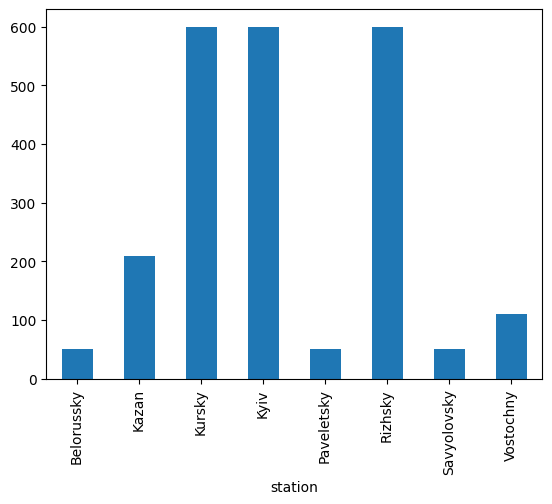

In [3]:
df.groupby('station')['review_text'].count().plot.bar()

### Обогащение данных с помощью модели с HuggingFace

Для обогащения данных можно использовать различные нейросетевые модели. Для начала, попробуем определить тональность текста.

Попробуем использовать модель [blanchefort/rubert-base-cased-sentiment-rurewiews](https://huggingface.co/blanchefort/rubert-base-cased-sentiment-rurewiews) с HuggingFace, натренированную на отзывах, с длиной 512 токенов. По умолчанию код из карточки модели выдает следующие классы:
* 0: NEUTRAL
* 1: POSITIVE
* 2: NEGATIVE

> Код не учитывает возможность работы на GPU, поэтому придётся внести в код несколько исправлений, чтобы можно было быстрее выполнять код на GPU.

In [4]:
import torch
from transformers import AutoModelForSequenceClassification
from transformers import BertTokenizerFast

device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = BertTokenizerFast.from_pretrained('blanchefort/rubert-base-cased-sentiment-rurewiews')
model = AutoModelForSequenceClassification.from_pretrained('blanchefort/rubert-base-cased-sentiment-rurewiews', return_dict=True)
model.to(device)

@torch.no_grad()
def predict(text):
    inputs = tokenizer(text, max_length=512, padding=True, truncation=True, return_tensors='pt')
    inputs = inputs.to(device)
    outputs = model(**inputs)
    predicted = torch.nn.functional.softmax(outputs.logits, dim=1)
    predicted = torch.argmax(predicted, dim=1).cpu().numpy()
    return predicted


/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Проверим, работает ли эта функция:

In [5]:
predict([
    'Ничего так вокзал, обычный...',
    'Обожаю этот вокзал, там такие симпатичные бомжи!',
    'Ненавижу это вокзал, поезда всегда опаздывают минимум на 20 минут'])

array([0, 1, 2])

Чтобы применить модель ко всему датасету, разобьем его на небольшие части, примерное по 200 отзывов, и предскажем тональность каждой из этих частей.

In [6]:
from tqdm.auto import tqdm
import numpy as np 

res = []
for d in tqdm(np.array_split(df,10)):
    z = list(d['review_text'])
    p = predict(z)
    res.extend(p)

100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


Для удобства вставим колонку `sentiment` в датасет, но при этом изменим кодирование: будем представлять негативный отзыв цифрой -1.

In [7]:
df['sentiment'] = pd.Series(res).apply(lambda x: -1 if x==2 else x)

Запишем получившийся датасет на диск:

In [8]:
df.to_csv('dataset_with_sentiment.csv',index=False)

Теперь можем посмотреть, какие вокзалы самые негативные или позитивные в Москве:

In [9]:
def count_pos(x):
    return x[x==1].count()
def count_neg(x):
    return x[x==-1].count()


df.groupby('station').agg({'sentiment' : ['mean', count_pos, count_neg ], 'review_text': 'count'})

sentiment                     review_text
                 mean count_pos count_neg       count
station                                              
Belorussky   0.680000        36         2          50
Kazan        0.647619       143         7         210
Kursky       0.395000       277        40         600
Kyiv         0.599332       385        26         599
Paveletsky   0.540000        27         0          50
Rizhsky      0.560000       374        38         600
Savyolovsky  0.480000        29         5          50
Vostochny    0.618182        71         3         110

В этом месте вы можете остановить виртуальную машину с GPU и перейти на более дешевый вариант **c1.4**

### Используем YandexGPT для извлечения смысла из отзывов

Попробуем использовать больщую языковую модель для извлечения структурированной информации из текстов отзывов. Для этого нам будет удобно использовать библиотеку [yandex_chain](https://github.com/yandex-datasphere/yandex-chain).

In [10]:
%pip install yandex_chain==0.0.8

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 926.7 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.5/973.5 kB 7.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.2/310.2 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 10.3 MB/s eta 0:00:00
  Created wheel for yandex_chain: filename=yandex_chain-0.0.8-py3-none-any.whl size=8413 sha256=36afeaaf72cf0da7b5fc1f967ccaaad3555fe81b70e6b4f24c1ab40696b856e5
  Stored in directory: /tmp/xdg_cache/pip/wheels/66/36/f5/43859afe9461bc9306b471dffbcbb638782badd8417a89d767
Successfully built yandex_chain
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.0.87
    Uninstalling langsmith-0.0.87:
      Successfully uninstalled langsmit

Для работы с YandexGPT, нам потребуются значения `api_key` и `folder_id`. Их надо взять из секретов датасферы.

In [2]:
import os

folder_id = os.environ['folder_id']
api_key = os.environ['api_key']
print(f"Using folder {folder_id}")

Using folder b1gbicod0scglhd49qs0


Создадим объект YandexGPT и проверим, как он работает:

In [3]:
from yandex_chain import YandexLLM, YandexGPTModel
LLM = YandexLLM(model=YandexGPTModel.Pro, folder_id=folder_id, api_key=api_key)

LLM.invoke("Расскажи анекдот про JSON и XML")

'Два программиста спорят, какой формат лучше для обмена данными: JSON или XML.\n\nПервый говорит: "XML - это как старый, классический автомобиль, он элегантный и красивый, но медленный и громоздкий".\n\nВторой возражает: "А JSON - это как спорткар, быстрый и гибкий, но не такой надёжный и безопасный".\n\nИ тут мимо них проносится молодой разработчик с языком программирования TypeScript:\n"Не понимаю, о чём вы спорите? Существует же новый формат - TSX, который объединяет лучшее от обоих миров!"'

Для обработки, чтобы ускорить процесс демонстрации, выберем по 10 записей из каждого вокзала:

In [4]:
import pandas as pd

df = pd.read_csv('dataset_with_sentiment.csv')
df_sample = df.groupby('station').apply(lambda x: x.sample(10)).reset_index(drop=True)
df_sample

,id,dislike,like,review_text,author,review_rating,datetime,station,sentiment
0,1252,0,5,"Расположен очень удобное, строятся новые пути ...",Пользователь Э.,5,2023-11-10T21:33:56.176Z,Belorussky,1
1,1266,2,15,"Снаружи вокзал выглядит впечатляюще, территори...",Всеволод П.,5,2024-03-28T05:24:50.784Z,Belorussky,0
2,1262,2,16,"Обожаю вокзал, из всех вокзалов , обладает так...",Алекс,5,2023-04-22T16:43:05.097Z,Belorussky,1
3,1287,10,9,Белорусский вокзал - просторный и комфортабель...,Иван Макаренков,5,2023-05-05T11:51:16.964Z,Belorussky,1
4,1255,2,7,С появление новых веток и маршрутов все стало ...,Татьяна Цымлова,5,2023-11-25T06:43:16.558Z,Belorussky,0
...,...,...,...,...,...,...,...,...,...
75,2266,0,1,"Отличный вокзал. Новый, современный, прям из в...",Анна Елагина,5,2024-02-02T04:55:15.074Z,Vostochny,1
76,2174,0,0,Хороший и вполне удобный вокзал. \nЗона ожидан...,Максим,5,2024-03-27T16:22:37.160Z,Vostochny,1
77,2251,0,0,Современный вокзал с интересным дизайном.\nУдо...,Ignat Kvik,5,2024-02-20T16:29:38.473Z,Vostochny,1
78,2222,10,9,"Люблю этот вокзал. Да, он небольшой и иногда п...",Аня Ф.,5,2023-12-07T11:36:27.862Z,Vostochny,1


Попробуем выделить смысл из текста отзыва. Для примера выберем три аспекта отзывов: транспортная доступность вокзала, его чистота и точность хождения поездов. По каждому из этих аспектов попробуем выделить оценку, также в целом положительные и отрицательные моменты, и список тегов, о чем этот отзыв.

In [5]:
prompt = """
Прочитай следующий отзыв о вокзале в тройных обратных кавычках: ````{}```.
Из этого отзыва тебе необходимо выделить следующую информацию:
* sentiment - этот отзыв позитивный (positive), негативный (negative) или нейтральный (neutral)
* transport - транспортная доступность вокзала, по шкале 1..5, если об это говорится в отзыве. Если нет - 0
* cleanliness - чистота вокзала, по шкале 1..5, если об это говорится в отзыве. Если нет - 0
* schedule - точность хождения поездов, по шкале 1..5, если об это говорится в отзыве. Если нет - 0
* positive - краткий список позитивных моментов из отзыва
* negative - краткий список негативных моментов из отзыва
* tags - краткий список тегов, о чем этот отзыв, например: cleanliness, transport, trains
Результат необходимо вернуть в формате JSON такого вида:
{{
  "sentiment" : "...",
  "transport" : ...,
  "cleanliness" : ...,
  "schedule" : ...,
  "positive" : ["...", ...],
  "negative" : ["...", ...],
  "tags" : ["..."]
}}
Обязательно пиши все строки внутри JSON в двойных кавычках. Не забывай ставить запятые после 
всех полей в JSON, кроме последнего.
"""

txt = df['review_text'].iloc[0]
print(txt)
res = LLM.invoke(prompt.format(txt))
res

Очень красивое место, вежливый персонал.
Ездила на поезде из Москвы в Беларусь, комфортно, белье чистое, тепло, можно с животными. Дают горячий чай прям в постель, можно даже не переутруждаться, там о вВс и вашем комфорте позаботиться квалифицированные сотрудники.


'{\n  "sentiment": "positive",\n  "transport": 0,\n  "cleanliness": 5,\n  "schedule": 0,\n  "positive": ["очень красивое место", "вежливый персонал", "комфортно", "чистое бельё", "тепло", "можно с животными", "дают горячий чай", "квалифицированные сотрудники"],\n  "negative": [],\n  "tags": ["вокзал"]\n}'

Поскольку возврат результата в формате JSON не гарантируется, попробуем использовать JsonOutputParser из библиотки LangChain для выделения результата в формате JSON. Но в дальнейшем если будут возникать ошибки парсинга - мы будет просто игнорировать такие строки.

In [6]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.exceptions import OutputParserException
jop = JsonOutputParser()

txt = df['review_text'].iloc[0]
print(txt)
res = jop.parse(LLM.invoke(prompt.format(txt)).replace('\'','"'))
res

Очень красивое место, вежливый персонал.
Ездила на поезде из Москвы в Беларусь, комфортно, белье чистое, тепло, можно с животными. Дают горячий чай прям в постель, можно даже не переутруждаться, там о вВс и вашем комфорте позаботиться квалифицированные сотрудники.


{'sentiment': 'positive',
 'transport': 0,
 'cleanliness': 5,
 'schedule': 0,
 'positive': ['красивое место',
  'вежливый персонал',
  'комфортно',
  'чистое бельё',
  'тепло',
  'можно с животными'],
 'negative': [],
 'tags': ['вокзал', 'поезд']}

Сохраним колонку `sentiment`, распознанную моделью HuggingFace.

In [7]:
pmap = { -1 : 'negative', 0 : 'neutral', 1 : 'positive' }
df_sample['hf_sentiment'] = df_sample['sentiment'].apply(lambda x: pmap[x])
df_sample.drop(columns=['sentiment'],inplace=True)

Теперь пройдёмся по всем строкам таблицы и извлечём информацию с помощью LLM. Для начала добавим новые пустые поля в таблицу, для хранения извлечённых значений:

In [9]:
import numpy as np

for f in ["sentiment","transport","cleanliness", "schedule", "positive", "negative", "tags"]:
    df_sample[f]=np.nan

Теперь собственно займёмся извлечением. Если для какого-то отзыва YandexGPT вернёт некорректный JSON, то отзыв будет пропущен. Мы можем запустить этот код несколько раз, чтобы попробовать распознать все отзывы. Он будет пропускать те отзывы, для которые поле `positive` уже заполнено.

> Обратите внимание, что мы используем несколько приёмов для уменьшения проблем с JSON. Например, если возвращенный JSON содержит вводный текст вида *Вот документ, который вы просили: {...}*, то мы выделяем весь текст между символами `{` и `}`. Также заменяем одинарные кавычки на двойные.

In [13]:
from tqdm.auto import tqdm
from yandex_chain import YException
import numpy as np

def lin(x):
    if isinstance(x,list):
        return ','.join(x)
    else:
        return x
    
def cut(x):
    if x.startswith('{'):
        return x
    if '{' in x and '}' in x:
        mk1 = x.find('{')
        mk2 = x.find('}', mk1) + 1
        return x[ mk1 : mk2 ]
    return x

for i,r in tqdm(df_sample.iterrows()):
    txt = r['review_text']
    if not pd.isnull(r['positive']):
        continue # уже распознано
    try:
        res = jop.parse(cut(LLM.invoke(prompt.format(txt)).replace('\'','"')))
        for f in ["sentiment","transport","cleanliness", "schedule", "positive", "negative", "tags"]:
            df_sample.at[i,f] = lin(res[f])
    except YException as ye:
        print(f"YandexGPT Error: {e}")
        break
    except Exception as e:
        print(f'Error: {e}') 

80it [00:04, 18.27it/s]


Посмотрим на результат:

In [14]:
df_sample.to_csv('dataset_sample_with_GPT.csv')
df_sample

,id,dislike,like,review_text,author,review_rating,datetime,station,hf_sentiment,sentiment,transport,cleanliness,schedule,positive,negative,tags
0,1252,0,5,"Расположен очень удобное, строятся новые пути ...",Пользователь Э.,5,2023-11-10T21:33:56.176Z,Belorussky,positive,positive,2.0,0.0,0.0,"удобное расположение,строительство новых путей...",состояние туалетов,"вокзал,транспортная доступность"
1,1266,2,15,"Снаружи вокзал выглядит впечатляюще, территори...",Всеволод П.,5,2024-03-28T05:24:50.784Z,Belorussky,neutral,positive,0.0,5.0,0.0,"впечатляюще,опрятная и приятная глазу территор...",небольшое помещение здания,"вокзал,территория,залы ожидания"
2,1262,2,16,"Обожаю вокзал, из всех вокзалов , обладает так...",Алекс,5,2023-04-22T16:43:05.097Z,Belorussky,positive,positive,1.0,0.0,0.0,"уникальная история,архитектурная интересность,...",,"вокзал,транспорт,Ласточка"
3,1287,10,9,Белорусский вокзал - просторный и комфортабель...,Иван Макаренков,5,2023-05-05T11:51:16.964Z,Belorussky,positive,positive,1.0,2.0,5.0,"просторный и комфортабельный вокзал,всегда чис...",,"вокзал,Белорусский вокзал,транспортная доступн..."
4,1255,2,7,С появление новых веток и маршрутов все стало ...,Татьяна Цымлова,5,2023-11-25T06:43:16.558Z,Belorussky,neutral,positive,0.0,0.0,0.0,"вокзал преображается,если несколько раз проеха...","все стало непонятным,нужно больше времени, что...",вокзал
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2266,0,1,"Отличный вокзал. Новый, современный, прям из в...",Анна Елагина,5,2024-02-02T04:55:15.074Z,Vostochny,positive,positive,5.0,4.0,0.0,"новый,современный,выход на МЦК и в метро",,"вокзал,транспортная доступность"
76,2174,0,0,Хороший и вполне удобный вокзал. \nЗона ожидан...,Максим,5,2024-03-27T16:22:37.160Z,Vostochny,positive,positive,0.0,0.0,0.0,"хороший вокзал,удобный вокзал,соответствует зо...",узковатая ширина платформы,
77,2251,0,0,Современный вокзал с интересным дизайном.\nУдо...,Ignat Kvik,5,2024-02-20T16:29:38.473Z,Vostochny,positive,positive,1.0,5.0,0.0,"современный вокзал с интересным дизайном,удобн...",,вокзал
78,2222,10,9,"Люблю этот вокзал. Да, он небольшой и иногда п...",Аня Ф.,5,2023-12-07T11:36:27.862Z,Vostochny,positive,positive,0.0,5.0,0.0,"уютно,свежий ремонт,дружелюбный и приветливый ...",,вокзал


## Делаем выводы и строим инфографику 

Посмотрим, насколько совпадают предсказания sentiment между YandexGPT и моделью с HuggingFace:

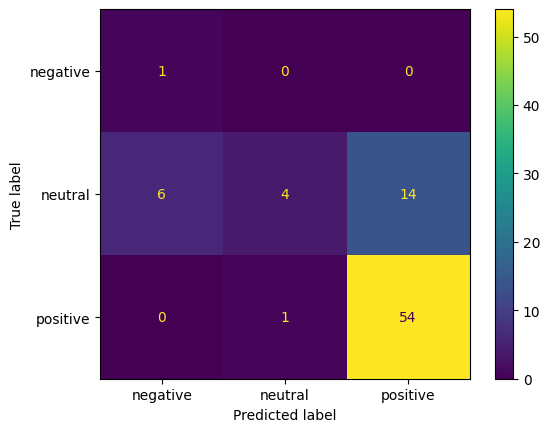

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(df_sample['hf_sentiment'],df_sample['sentiment'])

Посмотрим на средние значения показателей по всем вокзалам. Для этого сначала заменим нулевые значения на NaN, и затем осуществим аггрегацию:

In [16]:
for f in ["transport","cleanliness", "schedule"]:
    df_sample[f] = df_sample[f].apply(lambda x: np.nan if x==0 else x)

df_sample.groupby('station').agg( {'transport' : 'mean', 'cleanliness' : 'mean', 'schedule' : 'mean'})

,transport,cleanliness,schedule
station,,,
Belorussky,3.142857,3.666667,5.0
Kazan,3.000000,4.500000,NaN
Kursky,4.000000,5.000000,5.0
Kyiv,3.000000,4.333333,NaN
Paveletsky,2.857143,4.428571,NaN
Rizhsky,1.000000,4.800000,5.0
Savyolovsky,1.600000,4.428571,NaN
Vostochny,3.200000,4.000000,NaN


Такую же информацию можно представить в виде графика:

<Axes: xlabel='station'>

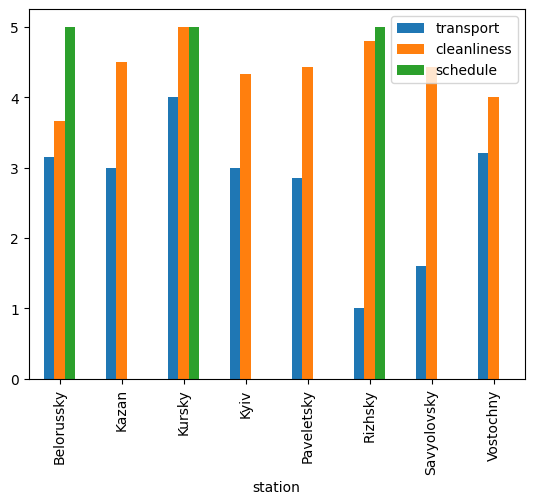

In [17]:
df_sample.groupby('station').agg(
    {'transport' : 'mean', 
     'cleanliness' : 'mean', 
     'schedule' : 'mean'}).plot.bar()

Теперь научимся извлекать интересующие нас отзывы по тегам. Для этого посмотрим на список всех тегов:

In [18]:
tags = list(df_sample['tags'].apply(lambda x: str(x).split(',')))
tags = set(sum(tags,[])) - { 'nan', '' }
tags

{'Архитектура',
 'Белорусский вокзал',
 'Вокзал',
 'Домодедово',
 'Киевский вокзал',
 'Ласточка',
 'Латвия',
 'Москва',
 'Обслуживание',
 'Павелецкая Плаза',
 'Пятёрочка',
 'Транспортная доступность',
 'Чистота',
 'аптека',
 'архитектура',
 'аэроэкспресс',
 'безопасность',
 'бомжи',
 'вокзал',
 'железнодорожный вокзал',
 'залы ожидания',
 'здание',
 'информирование',
 'кафе',
 'комфортная среда',
 'магазины',
 'метро',
 'музей',
 'музей на колёсах',
 'парковка',
 'поезд',
 'поезда',
 'привокзальная площадь',
 'пригородные поезда',
 'расположение',
 'ремонт',
 'реставрация',
 'стройплощадка',
 'таблоиды',
 'территория',
 'транспорт',
 'транспортная доступность',
 'туалет',
 'туризм',
 'чисто',
 'чистота'}

Опишем функцию `tag_lookup`, которая будет возвращать фрагмент таблицы, в который входит интересующий нас тег:

In [19]:
def tag_lookup(tag):
    return df_sample[df_sample['tags'].apply(lambda x: tag in str(x))]

tag_lookup('чистота')[['station','review_text']]

,station,review_text
3,Belorussky,Белорусский вокзал - просторный и комфортабель...
6,Belorussky,Очень уютный и удобный вокзал. Мне он очень нр...
20,Kursky,"Достаточно унылое место, с очень давящей атмос..."
30,Kyiv,Киевский вокзал столицы.Красивое архитектурное...
31,Kyiv,"Очень хорошая локация, отсюда можно добраться ..."
41,Paveletsky,Хорошо продуманная планировка и расположение в...
58,Rizhsky,"Один из красивых вокзалов, спокойный и тихий, ..."
59,Rizhsky,"Надежная, не навязчивая охрана. Ухоженной и оч..."
63,Savyolovsky,"Удобная станция в целом. Рядом с метро, через ..."
64,Savyolovsky,"Хороший вокзал, точнее пересадка с метро рядом..."


Посмотрим, на каком вокзале есть музей:

In [20]:
tag_lookup('музей')[['station','review_text']]

,station,review_text
55,Rizhsky,"одновременно и вокзал, и памятник архитектуры...."
56,Rizhsky,Здание вокзала чистое и очень красивое. Просто...


## Подведение итогов

Зададимся задачей подытожить все положительные и отрицательные моменты для каждого из вокзалов. Сначала объединим все значения колонок `positive` и `negative` для каждого из вокзалов:

In [21]:
join = lambda x : ', '.join([t for t in x if len(t)>0])

df_stations = df_sample.groupby('station').agg({ 'positive' : join, 'negative' : join }).reset_index()
df_stations

,station,positive,negative
0,Belorussky,"удобное расположение,строительство новых путей...","состояние туалетов, небольшое помещение здания..."
1,Kazan,"удобно, тихо и спокойно,детская игровая комнат...","не хватает света внутри вокзала, там отдыхают ..."
2,Kursky,"чисто, удобное расположение для выезда в город...","унылое место, с очень давящей атмосферой, идёт..."
3,Kyiv,"красивое архитектурное здание,отличная подсвет...",Стоит поработать и выполнить устройство навесо...
4,Paveletsky,"чисто,вежливы и доброжелательны работники проп...",надо немножко пораньше приехать до отправления...
5,Rizhsky,"красивое здание,внутри чисто, тихо и уютно,туа...",
6,Savyolovsky,"спокойное место,вокзал отремонтирован,туалеты ...",зимой не всегда оперативно убирают снег по цен...
7,Vostochny,"лёгкая и быстрая пересадка с метро,станция мет...","может не хватать мест в ожидании поезда, неудо..."


Теперь применим большую языковую модель для того, чтобы суммаризировать все факты в один конкретный текст:

In [22]:
prompt_sum = """
Пожалуйста, прочитай список отзывов о вокзале ниже в тройных обратных кавычках и запиши краткое содержание
всего прочитанного текста в виде нескольких абзацев текста. Отзывы: ```{}```
"""

def summarize(x):
    res = LLM.invoke(prompt_sum.format(x))
    return res

df_stations['pos_summary'] = df_stations['positive'].apply(summarize)
df_stations['neg_summary'] = df_stations['negative'].apply(summarize)

In [23]:
from IPython.display import display
with pd.option_context('display.max_colwidth', 0):
    display(df_stations[['station','pos_summary','neg_summary']])

,station,pos_summary,neg_summary
0,Belorussky,"Вокзал получил положительные отзывы за удобное расположение и транспортную доступность, включая парковку, метро и автобусы. Отмечается его современное оформление и уютность, а также наличие кафе и магазинов.\n\nПосетители отмечают впечатляющую опрятную территорию вокзала с удобной зарядкой для телефонов. Выделяются удобное расположение вокзала, позволяющее легко добраться до любой точки Москвы, и наличие розетки для зарядки телефона в зале ожидания. \n\nВокзал претерпел изменения, став красивее, современнее и удобнее. Отмечено улучшение в частоте электричек и повышение уровня комфорта при их использовании. Посетители также положительно оценивают обновлённый навес, электронное табло и памятник «Прощание славянки».","По отзывам о вокзале можно сделать вывод, что у посетителей возникают сложности с поиском нужных мест. Кроме того, среди недостатков отмечают состояние туалетов и небольшую площадь здания.\n\nНекоторые из посетителей указывают на то, что после окончания стройки требуется ещё некоторое время для завершения всех работ и устранения недочётов. Также есть мнение, что информации о том, куда нужно идти, недостаточно.\n\nВ целом, отзывы отражают трудности и неудобства, с которыми сталкиваются посетители вокзала, включая проблемы с ориентацией в пространстве и состоянием инфраструктуры."
1,Kazan,"Вокзал представляет собой удобное место для ожидания поездов и электричек. \n\nПассажиры отмечают его **комфортную обстановку**, **чистые помещения** и **спокойную атмосферу**. Положительно оценивается удобная **архитектура**, а также возможность скоротать время в ожидании поезда в **многочисленных кафе** и магазинах, таких как «Пятёрочка» и «Лента».\n\nОтзывы указывают на наличие **детской игровой комнаты**, достаточное количество мест для отдыха, ожидаемо **невысокие цены** на товары и услуги. В здании вокзала расположены **камеры хранения** и **зарядки для телефонов**. Вокзал удобно расположен с точки зрения транспортной доступности, к нему легко подъехать.\n\nВажными преимуществами вокзала пассажиры считают **близость метро**, а также **расположение в одном комплексе** с продуктовым магазином.\n\nНекоторые удобства делают пребывание на вокзале максимально комфортным — это **большие залы ожидания** с удобными креслами, **вместительные камеры хранения**, **удобные кассовые залы**. \n\nВ целом отзывы положительные, они отмечают **удобство и комфорт** вокзала, подчёркивая его приспособленность для пассажиров.","Во многих отзывах о вокзале отмечается ряд недостатков, среди которых – нехватка освещения внутри здания. Это вызывает определённые неудобства и может влиять на уровень безопасности.\n\nУпоминается, что вокзал является местом отдыха и общения представителей определённых социальных групп, которые вызывают недовольство других посетителей. Многие посетители вокзала отмечают высокие цены на товары и услуги в кафе и магазинах, а также сомневаются в качестве продаваемой продукции. В магазинах обнаружены товары с наценкой в 100%.\n\nДанные отзывы подчёркивают необходимость улучшения условий для посетителей и предоставления качественных услуг и товаров. Возможно, повышение уровня комфорта и безопасности позволит сделать вокзал более привлекательным для большего числа людей."
2,Kursky,"Вокзал, о котором идёт речь в отзывах, представляется чистым и удобным местом с точки зрения расположения: он находится близко к выезду в город и удобен для посадки на такси. \n\nНа вокзале много мест для отдыха на улице. Здание вокзала большое и просторное. Оно вызывает у посетителей чувство ностальгии, если они бывали здесь раньше. Многие считают его самым красивым вокзалом. Здание выполнено отлично, с продуманной навигацией. Люди на вокзале отзывчивые, а атмосфера благожелательная. Безопасность посетителей — один из главных приоритетов. \n\nВокзал отличается большим размером, удобством и наличием парковки для таксистов прямо у входа.","Вокзал описывается как унылое место с давящей атмосферой, где идёт ре

## Заключение

На этом ваша работа над задачей только начинается! Вы можете отталкиваться от приведённого в этом примере кода, или взять только данные и придумать какой-то свой способ анализа отзывов и подведения по ним итогов. Пробуйте применять другие модели с HuggingFace, пробуйте другие языковые модели, обогащайте данные дополинетельными источниками - но не забывайте использовать всё богатство инструментов ИИ, которое вы изучали, и которое даём вам Yandex Cloud!